In [2]:
import pandas as pd
import numpy as np
import matplotlib
import nilearn
from nilearn.datasets import fetch_spm_auditory

### GLM analysis
* single subject, single run
* example of GLM analysis
* w/ Auditory Stimulation alternating w/ Rest
  * each lasting 42s each (6 scans w/ 7s TR)
  * 64 x 64 x 64 3mm x 3mm x 3mm voxels

## Download and load data

In [3]:
subject_data = fetch_spm_auditory()
# print paths of first 5 func images
print(*subject_data.func[:5], sep="\n")  


Dataset created in /home/jk/nilearn_data/spm_auditory

Data absent, downloading...


Downloaded 30720000 of 34212021 bytes (89.8%,    0.8s remaining) ...done. (9 seconds, 0 min)
Extracting data from /home/jk/nilearn_data/spm_auditory/sub001/MoAEpilot.zip..... done.


/home/jk/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img
/home/jk/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img
/home/jk/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img
/home/jk/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img
/home/jk/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img


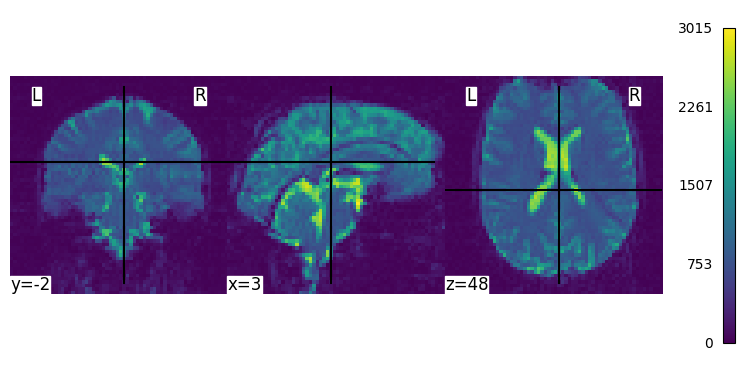

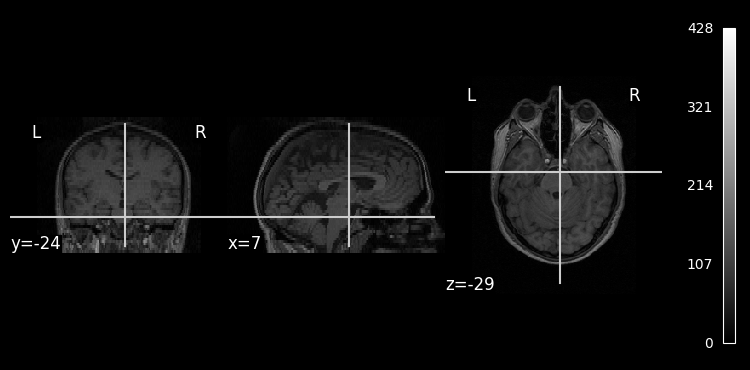

In [4]:
from nilearn.plotting import plot_anat, plot_img, plot_stat_map

plot_img(subject_data.func[0], colorbar=True, cbar_tick_format="%i")
plot_anat(subject_data.anat, colorbar=True, cbar_tick_format="%i")

### Concatenate 3D EPI vols from each scan of the run into a 4D image
* compute mean for background image of future plots

In [6]:
from nilearn.image import concat_imgs, mean_img

fmri_img = concat_imgs(subject_data.func)
mean_img = mean_img(fmri_img)

In [7]:
events = pd.read_table(subject_data["events"])
events.head()

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest


### 1st level GLM analysis
* Generate Design Matrix from events object

In [8]:
from nilearn.glm.first_level import FirstLevelModel

### First-level model Parameters
* define model in python object
* fit model on 4D image

In [10]:
fmri_glm = FirstLevelModel(
    t_r=7,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm",
    drift_model="cosine",
    high_pass=0.01,
)
fmri_glm = fmri_glm.fit(fmri_img, events)

#### Inspect Design matrix 
* rows represent time
* columns are predictors

In [11]:
design_matrix = fmri_glm.design_matrices_[0]

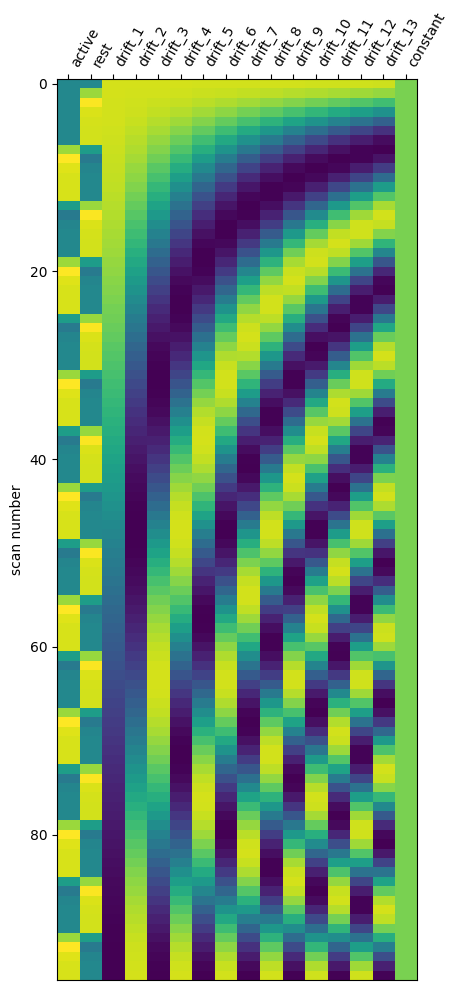

In [12]:
import matplotlib.pyplot as plt

from nilearn.plotting import plot_design_matrix

plot_design_matrix(design_matrix)

plt.show()

Create directory and save design matrix to disk

In [13]:
from pathlib import Path

output_dir = Path.cwd() / "results" / "plot_single_subject_single_run"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

plot_design_matrix(design_matrix, output_file=output_dir / "design_matrix.png")

Output will be saved to: /home/jk/repos/fmri_analysis/results/plot_single_subject_single_run


### Column 1 labeled "active" holds the expected response profile of regions sensitive to auditory stimulation

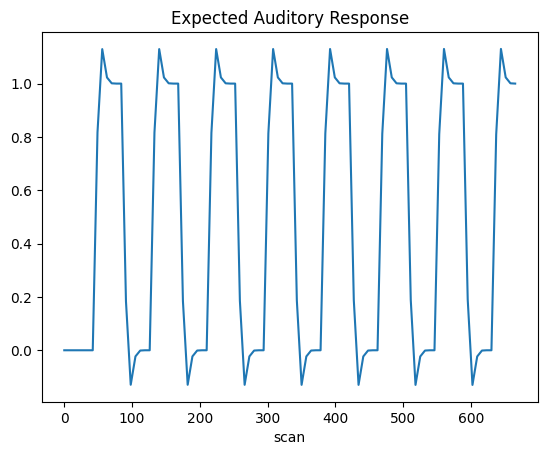

In [14]:
plt.plot(design_matrix["active"])
plt.xlabel("scan")
plt.title("Expected Auditory Response")
plt.show()

### Detect voxels with significant effects
* w/ contrasts of estimated coefficients

In [15]:
import numpy as np

conditions = {"active": np.zeros(16), "rest": np.zeros(16)}
conditions["active"][0] = 1
conditions["rest"][1] = 1

In [16]:
conditions

{'active': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'rest': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

### Define contrast & plot Design Matrix
* active minus rest

<Axes: label='conditions'>

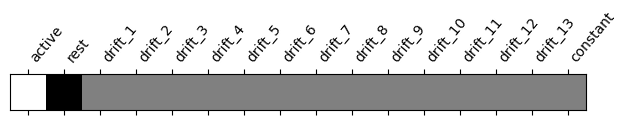

In [18]:
from nilearn.plotting import plot_contrast_matrix
active_minus_rest = conditions["active"] - conditions["rest"]

plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)

#### Compute 'Estimated effect'
* in BOLD signal unit

In [19]:
eff_map = fmri_glm.compute_contrast(
    active_minus_rest, output_type="effect_size"
)

### Compute Statistical Significance
* form t-statistic and convert it to z-score

In [21]:
z_map = fmri_glm.compute_contrast(active_minus_rest, output_type="z_score")

### Plot Z score map (active - rest)
* with threshold of 3

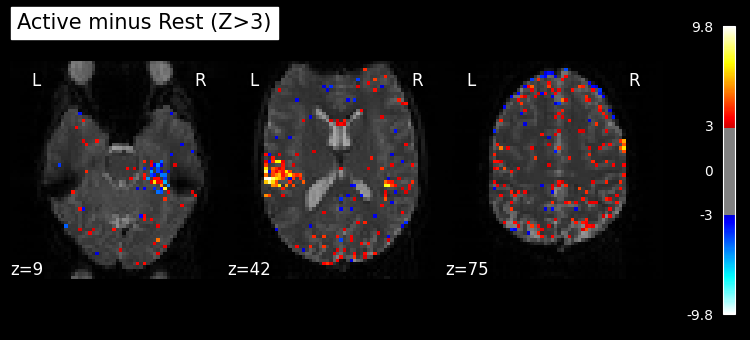

In [22]:
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=3.0,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (Z>3)",
)
plt.show()

### Uncorrected Threshold zscore map
#### Statistical Signficance at alpha level 0.001

Uncorrected p<0.001 threshold: 3.291


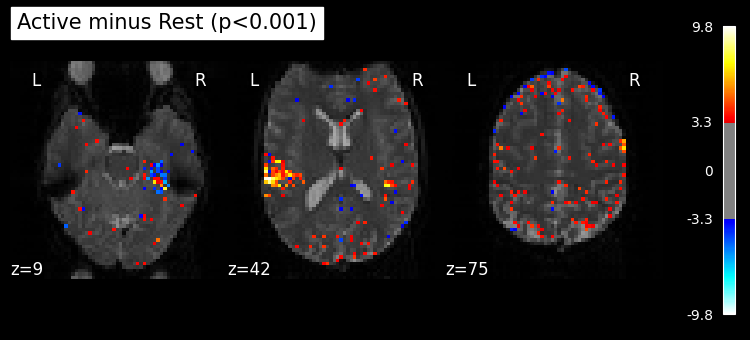

In [23]:
from nilearn.glm import threshold_stats_img

_, threshold = threshold_stats_img(z_map, alpha=0.001, height_control="fpr")
print(f"Uncorrected p<0.001 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (p<0.001)",
)
plt.show()

Family Wise Error Rate correction
*  i.e. the probability of making only one false detection, say at 5%.
* 1st we'll take a look at the extremely conservative Bonverroni correction

Bonferroni-corrected, p<0.05 threshold: 4.934


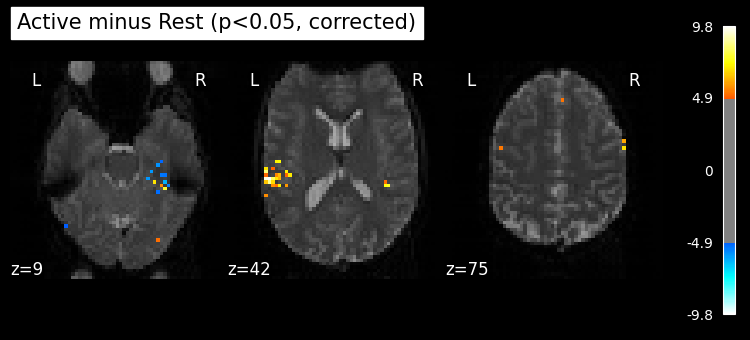

In [24]:
_, threshold = threshold_stats_img(
    z_map, alpha=0.05, height_control="bonferroni"
)
print(f"Bonferroni-corrected, p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (p<0.05, corrected)",
)
plt.show()

## False Discovery Rate
A popular alternative is to control the expected proportion of false discoveries among detctions

False Discovery rate = 0.05 threshold: 2.904


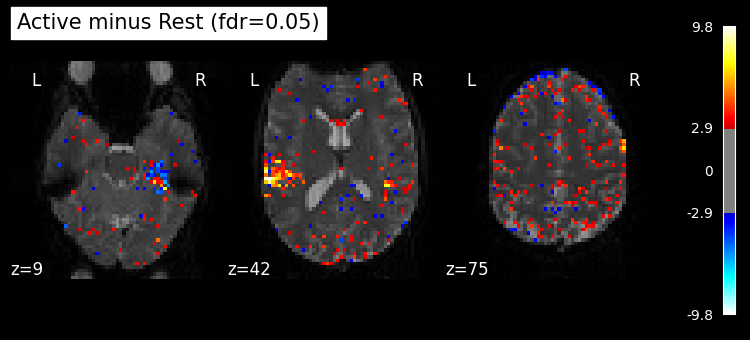

In [25]:
_, threshold = threshold_stats_img(z_map, alpha=0.05, height_control="fdr")
print(f"False Discovery rate = 0.05 threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (fdr=0.05)",
)
plt.show()

### Remove isolated voxels
* or "small clusters"
* by providing a cluster_threshold
* 10 here

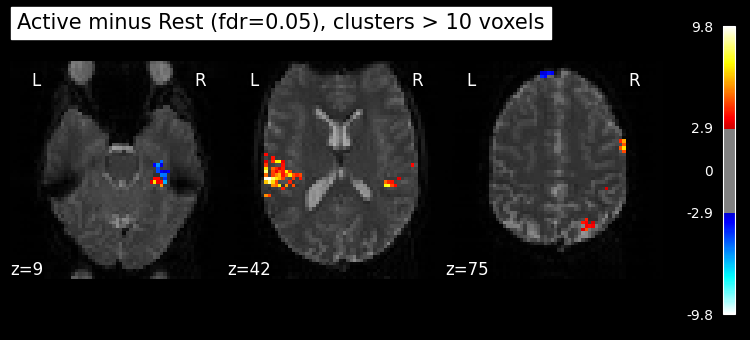

In [26]:
clean_map, threshold = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr", cluster_threshold=10
)
plot_stat_map(
    clean_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Active minus Rest (fdr=0.05), clusters > 10 voxels",
)
plt.show()

### Save effect and zscore maps

In [27]:
z_map.to_filename(output_dir / "active_vs_rest_z_map.nii.gz")
eff_map.to_filename(output_dir / "active_vs_rest_eff_map.nii.gz")

# Extract positions of significant clusters

In [28]:
from nilearn.reporting import get_clusters_table

table = get_clusters_table(
    z_map, stat_threshold=threshold, cluster_threshold=20
)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-60.0,-6.0,42.0,9.811979,4050
1,1a,-63.0,6.0,36.0,8.601922,
2,1b,-63.0,0.0,42.0,8.435063,
3,1c,-48.0,-15.0,39.0,8.364058,
4,2,60.0,0.0,36.0,9.605128,1512
5,2a,45.0,-12.0,42.0,7.590200,
6,3,63.0,12.0,27.0,8.253889,972
7,3a,51.0,3.0,30.0,6.968355,
8,3b,54.0,9.0,39.0,3.565609,
9,4,36.0,-3.0,15.0,8.087451,1188


In [29]:
## save table
table.to_csv(output_dir / "table.csv")

### Example F-test
* Here we test which voxels are well explained by the combination of the active *and* rest conditions

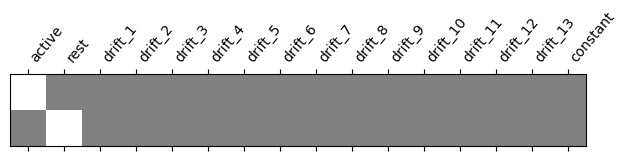

In [30]:
effects_of_interest = np.vstack((conditions["active"], conditions["rest"]))
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

z_map = fmri_glm.compute_contrast(effects_of_interest, output_type="z_score")

The statistic was converted to a z-variable, making it easier to represent

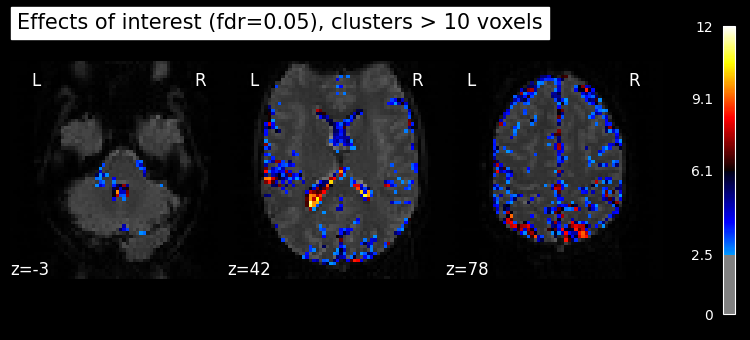

In [32]:
clean_map, threshold = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr", cluster_threshold=10
)
plot_stat_map(
    clean_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="Effects of interest (fdr=0.05), clusters > 10 voxels",
)
plt.show()

Here, most of the differences are non-neural signal, i.e., in the ventricals, arteries